# Comparing SODA an WOA datasets
for model validation

# <span style='color:Green'> SODA 3.4.2

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(20)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.4d19043da1374b02b1adbd1aa78802ec/status,


In [173]:
client.close()
cluster.close()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
import gsw
from xhistogram.xarray import histogram
import fastjmd95 
from fastjmd95 import jmd95numba
import json

In [4]:
woa_8110 = xr.open_dataarray('/home/jovyan/WMT-project/WOA/ts_hist_8110.nc')
woa_0517 = xr.open_dataarray('/home/jovyan/WMT-project/WOA/ts_hist_0517.nc')
soda_old = xr.open_dataarray('/home/jovyan/WMT-project/SODA/ts_hist_mean_SODA.nc')
soda = xr.open_dataarray('/home/jovyan/WMT-project/SODA/ts_hist_mean_SODA_new.nc')

In [5]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem(requester_pays=True)
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True)#, decode_times=False)

In [6]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

cells = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SODA/datasets/cells_wg.zarr'))

/tmp/ipykernel_327/656088719.py:5: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  cells = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SODA/datasets/cells_wg.zarr'))


In [7]:
#fix time dim (1898/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

In [8]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [9]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_top = dict(grid_y_T=slice(lower_lat, upper_lat))
lon_range_top = dict(grid_x_T=slice(left_lon, right_lon))

In [10]:
ds_wg = ocean.isel(**lat_range, **lon_range)

In [11]:
#have to give the 2 endpts same date for avging to work and keep the 12-24 timestamp
salt19 = ds_wg.salt.sel(time='2018-12-19').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})
salt29 = ds_wg.salt.sel(time='2018-12-29').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})

temp19 = ds_wg.temp.sel(time='2018-12-19').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})
temp29 = ds_wg.temp.sel(time='2018-12-29').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})

salt25 = ds_wg.salt.sel(time='1993-12-25').to_dataset().assign_coords({'time':ds_wg.time.sel(time='1993-12-30')})
salt04 = ds_wg.salt.sel(time='1994-01-04').to_dataset().assign_coords({'time':ds_wg.time.sel(time='1993-12-30')})

In [12]:
#avging the two endpts to insert onto 12-24 date instead of it being 0 (will help solve spike in timeseries)
salt24_ds = (salt19+salt29)/2
salt24 = salt24_ds.salt

temp24_ds = (temp19+temp29)/2
temp24 = temp24_ds.temp

#avging the two endpts to insert onto 1993-12-30 since there is a spike on that date due to nudging
salt30_ds = (salt25+salt04)/2
salt30 = salt30_ds.salt

In [13]:
#inserting avged salt/temp values on 12-24 date into ds_wg
ds_wg['salt'][1897] = salt24[0]
ds_wg['temp'][1897] = temp24[0]

#inserting avged salt value on 1993-12-30 date into ds_wg
ds_wg['salt'][72] = salt30[0]

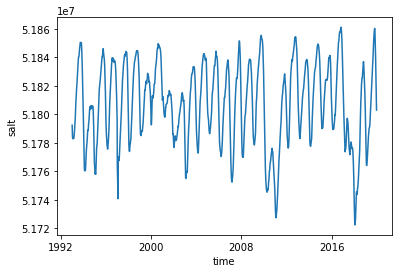

In [36]:
ds_wg.salt.sum(['st_ocean', 'yt_ocean', 'xt_ocean']).plot()

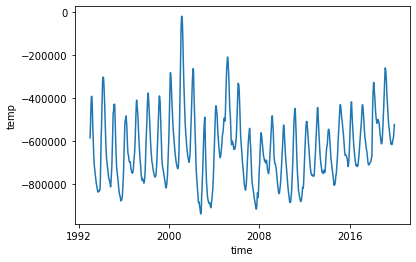

In [37]:
ds_wg.temp.sum(['st_ocean', 'yt_ocean', 'xt_ocean']).plot()

In [126]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.ac210cadc40047a9aeae8289f82f1098/status,


In [21]:
mask = ((ds_wg.temp.isel(time=10) > -0.001) & (ds_wg.temp.isel(time=10) < 0))#.astype(float)
mask_timeseries = mask.sum(("yt_ocean", "xt_ocean", "st_ocean")).compute()

In [22]:
new_mask = ((ds_wg.temp.isel(time=10) < -0.001) & (ds_wg.temp.isel(time=10) > 0))
new_mask_timeseries = new_mask.sum(("yt_ocean", "xt_ocean", "st_ocean")).compute()

In [39]:
new_mask = ((ds_wg.temp < -0.001) | (ds_wg.temp > 0)).isel(time=10).compute()

In [40]:
new_mask.sum()

<xarray.DataArray 'temp' ()>
array(1482503)
Coordinates:
    time     object 1993-02-23 13:00:00

In [41]:
T_bins

NameError: name 'T_bins' is not defined

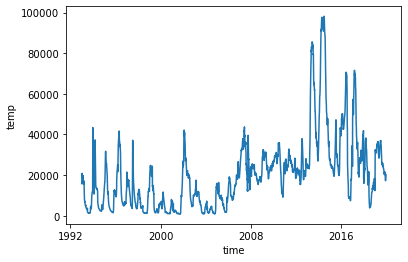

In [16]:
mask_timeseries.plot()

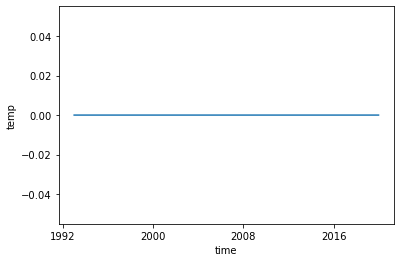

In [17]:
new_mask_timeseries.plot()

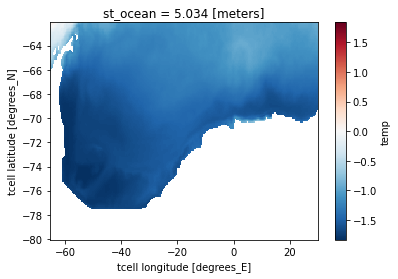

In [155]:
ds_wg.temp.mean('time')[0].plot()

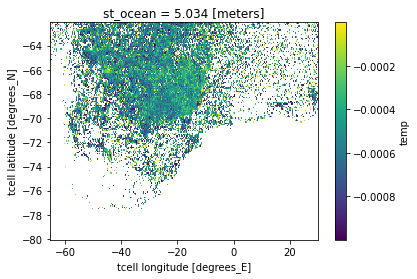

In [133]:
ds_wg.temp.where(mask).mean('time')[0].plot()

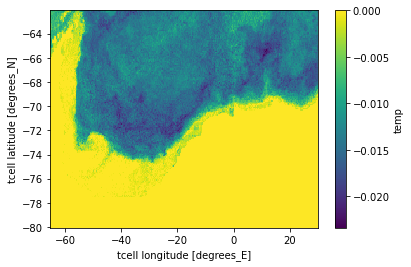

In [134]:
ds_wg.temp.where(mask).mean('time').sum('st_ocean').plot()

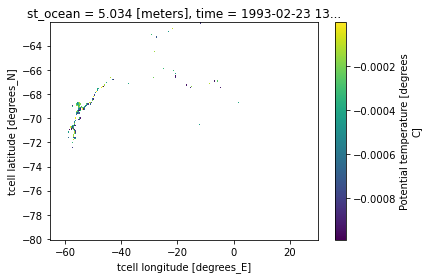

In [166]:
ds_wg.temp.where(mask)[10,0].plot()

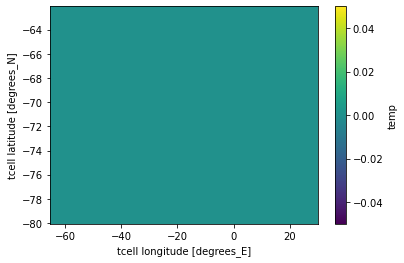

In [168]:
ds_wg.temp.where(new_mask).mean('time').sum('st_ocean').plot()

In [100]:
mask_na = ds_wg.temp.isnull()
# 0 is False and 1 is True

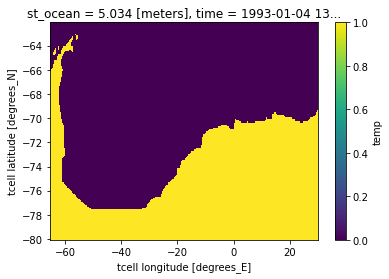

In [95]:
mask_na[0,0].plot()

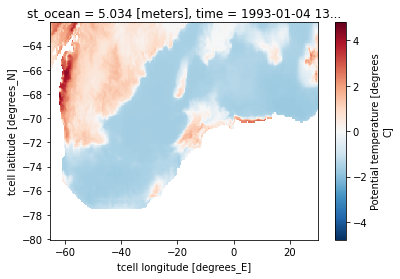

In [97]:
ds_wg.temp[0,0].plot()

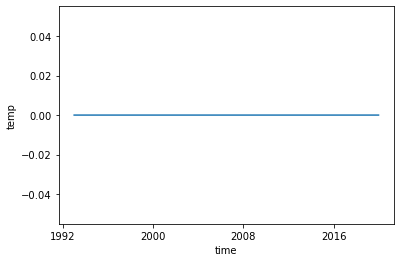

In [172]:
new_mask_timeseries.plot()

In [29]:
new_mask.load()

<xarray.DataArray 'temp' (st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
    time      object 1993-02-23 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [31]:
new_mask.dtype

dtype('float64')

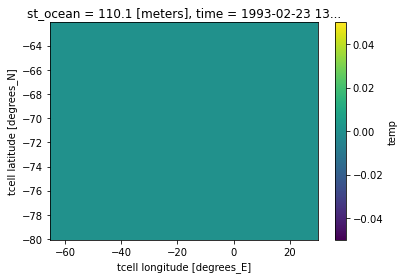

In [30]:
new_mask[10].plot()

In [42]:
t_bins = np.linspace(-2, 2, 1000)
t_hist_newmask = histogram(ds_wg.temp.isel(time=10).where(new_mask), bins=[t_bins], dim=("yt_ocean", "xt_ocean", "st_ocean")).compute()
t_hist_newmask

<xarray.DataArray 'histogram_temp' (temp_bin: 999)>
array([    0,     0,     0,     0,     0,     1,     1,     1,     0,
           0,     1,     1,     0,     0,     0,     1,     1,     0,
           2,     0,     1,     0,     3,     2,     1,     1,     1,
           4,     3,     8,    10,    94,  1467,  1661,  2806,  3115,
        2782,  2422,  2089,  2047,  1966,  2082,  2030,  1894,  1865,
        1707,  1746,  1570,  1514,  1556,  1452,  1516,  1391,  1311,
        1258,  1369,  1352,  1302,  1257,  1265,  1234,  1273,  1295,
        1307,  1269,  1226,  1193,  1137,  1212,  1122,  1171,  1101,
        1062,  1061,  1090,  1022,  1080,  1100,  1067,  1037,  1079,
        1063,  1072,  1078,  1058,  1115,  1077,  1086,  1090,  1087,
        1106,  1083,  1110,  1187,  1159,  1198,  1168,  1191,  1203,
        1211,  1302,  1282,  1332,  1283,  1356,  1226,  1294,  1436,
        1379,  1414,  1407,  1404,  1452,  1395,  1427,  1465,  1548,
        1482,  1442,  1472,  1453,  1427,  1433,  1445,  1403,  1465,
        1372,  1450,  1441,  1394,  1376,  1317,  1352,  1357,  1343,
        1336,  1335,  1338,  1293,  1283,  1317,  1346,  1277,  1259,
        1254,  1295,  1266,  1237,  1213,  1332,  1245,  1329,  1300,
        1255,  1264,  1241,  1195,  1271,  1201,  1319,  1233,  1236,
        1259,  1173,  1201,  1182,  1166,  1195,  1205,  1180,  1195,
        1187,  1201,  1098,  1109,  1069,  1148,  1090,  1078,  1167,
...
         156,   159,   165,   147,   137,   128,   142,   119,   139,
         100,   126,   127,   128,   139,   134,   135,   135,   114,
         110,   127,   110,   108,    98,    88,   124,   104,   105,
         107,    95,    97,    99,    92,    97,   106,   117,    93,
          90,    95,   108,   109,   102,   111,   122,    89,   105,
          89,    88,    91,    94,   118,   103,   107,   100,    85,
          89,    91,    98,    77,    75,    80,    93,    89,    90,
          88,   102,   101,    87,    98,    92,    86,    78,    90,
          62,    69,    70,    82,    65,    68,    63,    67,    88,
          70,    70,    66,    55,    65,    54,    57,    65,    64,
          65,    82,    62,    59,    63,    59,    74,    57,    47,
          60,    61,    47,    68,    61,    55,    39,    54,    54,
          53,    46,    40,    40,    45,    48,    48,    36,    47,
          46,    47,    35,    50,    46,    43,    41,    45,    45,
          50,    39,    41,    39,    30,    39,    37,    33,    41,
          26,    33,    22,    36,    37,    44,    34,    35,    29,
          41,    27,    30,    24,    33,    43,    40,    31,    44,
          30,    31,    23,    33,    34,    28,    29,    26,    23,
          33,    24,    25,    24,    31,    32,    18,    21,    18,
          28,    34,    18,    19,    19,    11,    21,    19,    20])
Coordinates:
  * temp_bin  (temp_bin) float64 -1.998 -1.994 -1.99 -1.986 ... 1.99 1.994 1.998

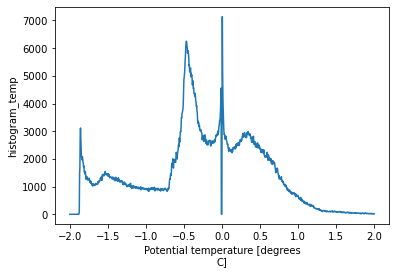

In [52]:
t_bins = np.linspace(-2, 2, 1000)
T = ds_wg.temp.isel(time=10).compute()
mask = (T > 0.001) | (T < -0.01)
t_hist = histogram(T.where(mask), bins=[t_bins], dim=("yt_ocean", "xt_ocean", "st_ocean"))
t_hist.plot()

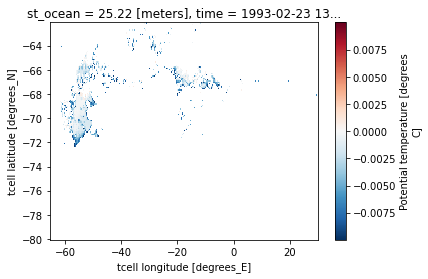

In [58]:
T.where(~mask)[2].plot()

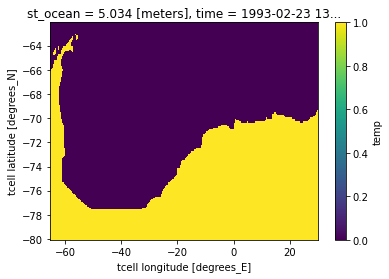

In [59]:
T.isnull()[0].plot()

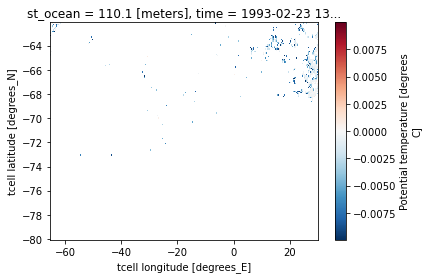

In [54]:
T.where(~mask)[10].plot()

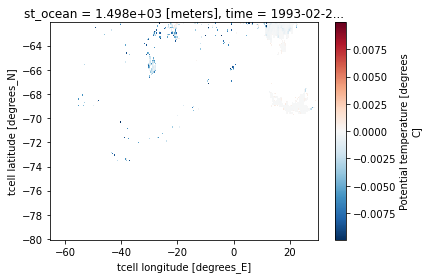

In [55]:
T.where(~mask)[30].plot()

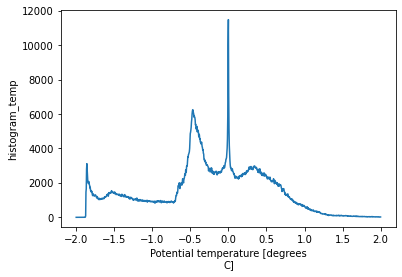

In [47]:
t_hist.plot()

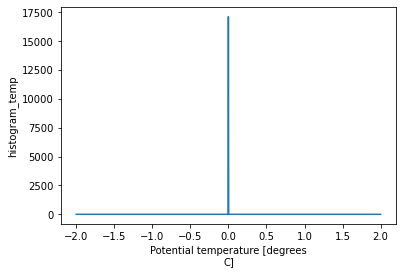

In [25]:
t_hist.T.plot()

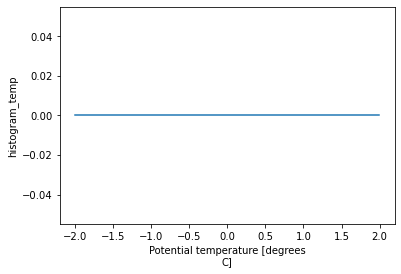

In [26]:
t_hist_newmask.T.plot()

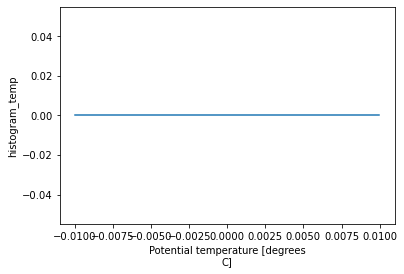

In [137]:
t_hist.mean('time').plot()

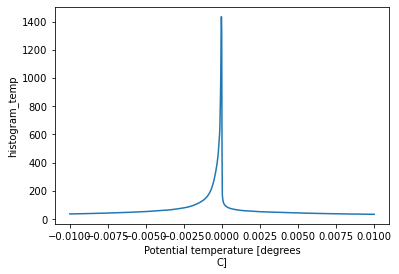

In [111]:
t_hist.mean('time').plot()

(-0.0005, 1e-05)

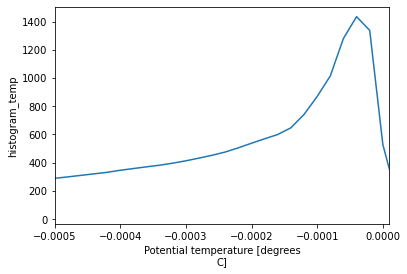

In [122]:
t_hist.mean('time').plot()
plt.xlim(-0.0005, 0.00001)

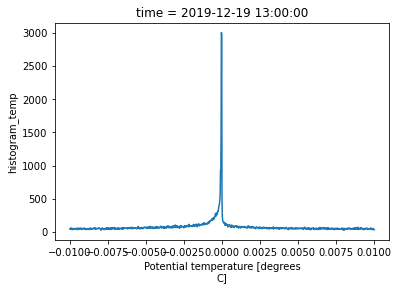

In [112]:
t_hist[-1].plot()

In [48]:
t_hist_fillna = histogram(ds_wg.temp.fillna(-999), bins=[t_bins], dim=("yt_ocean", "xt_ocean", "st_ocean")).compute()

In [86]:
t_hist_fillna

<xarray.DataArray 'histogram_temp' (time: 1970, temp_bin: 499)>
array([[ 2,  1,  1, ..., 42, 44, 47],
       [ 3,  1,  1, ..., 53, 62, 53],
       [ 0,  0,  0, ..., 46, 46, 51],
       ...,
       [ 0,  1,  1, ...,  8,  9,  7],
       [ 0,  0,  0, ...,  7, 11,  5],
       [ 0,  0,  0, ..., 10,  3,  7]])
Coordinates:
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * temp_bin  (temp_bin) float64 -1.996 -1.988 -1.98 -1.972 ... 1.98 1.988 1.996

(-2.0, 0.05)

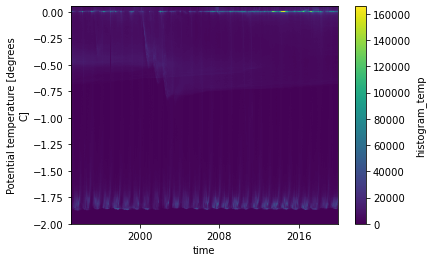

In [90]:
t_hist_fillna.T.plot()
plt.ylim(-2,0.05)

(-0.01, 0.01)

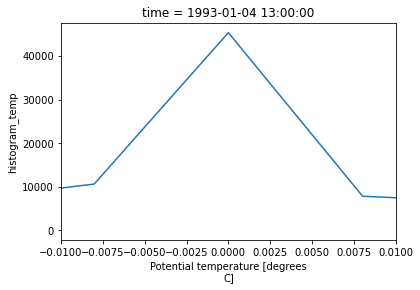

In [57]:
t_hist_fillna[0].plot()
plt.xlim(xmin=-0.01, xmax=0.01)

(-0.001, 0.001)

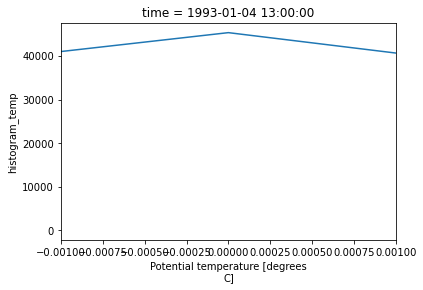

In [105]:
t_hist_fillna[0].plot()
plt.xlim(xmin=-0.001, xmax=0.001)

(-0.001, 0.001)

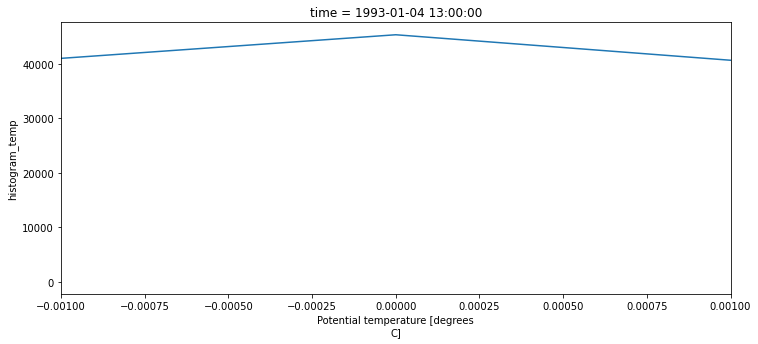

In [109]:
plt.figure(figsize=(12,5))
t_hist_fillna[0].plot()
plt.xlim(xmin=-0.001, xmax=0.001)

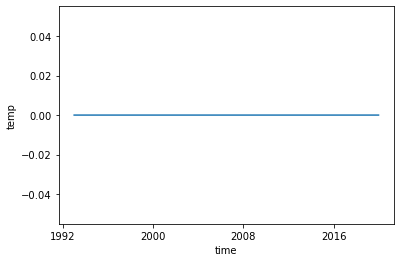

In [42]:
mask_timeseries.plot()

In [63]:
mask1 = ds_wg.temp.where(ds_wg.temp==0)
mask_timeseries1 = mask1.sum(("yt_ocean", "xt_ocean", "st_ocean")).compute()

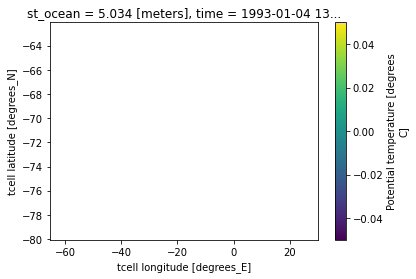

In [74]:
mask1[0,0].plot()

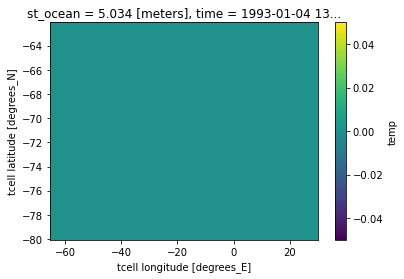

In [73]:
mask[0,0].plot()

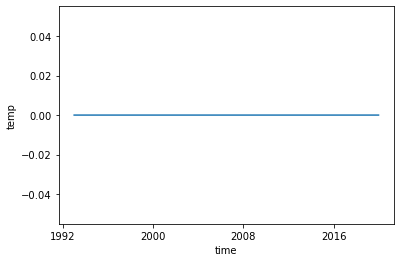

In [72]:
mask_timeseries.plot()

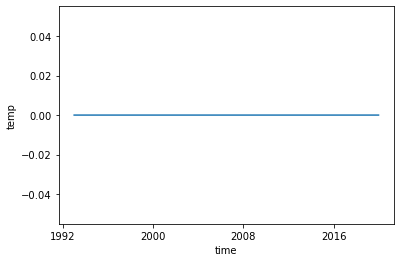

In [71]:
mask_timeseries1.plot()

In [138]:
#salt_bins = np.linspace(31.5, 35.5, 100)
#theta_bins = np.linspace(-2, 4, 100)
salt_bins = np.linspace(31, 35, 100)
theta_bins = np.linspace(-2.5, 8, 100)
delta_salt = salt_bins[1] - salt_bins[0]
delta_theta = theta_bins[1] - theta_bins[0]

vol = cells.dx_interp * cells.dy_u * cells.dz

In [139]:
ts_hist = histogram(ds_wg.temp.where(new_mask), ds_wg.salt, 
                    bins=[theta_bins, salt_bins],
                    weights=vol, 
                    dim=['xt_ocean', 'yt_ocean', 'st_ocean']).rename({'temp_bin':'theta_bin', 
                                                                      'salt_bin':'salt_bin'}) / (delta_salt * delta_theta)
ts_hist.load()

<xarray.DataArray 'histogram_temp_salt' (time: 1970, theta_bin: 99, salt_bin: 99)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * time       (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [142]:
#taking hist mean over `time` takes average (notice the scales are diff in either plots)
ts_hist_mean = ts_hist.mean(dim='time')

In [147]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.ac210cadc40047a9aeae8289f82f1098/status,


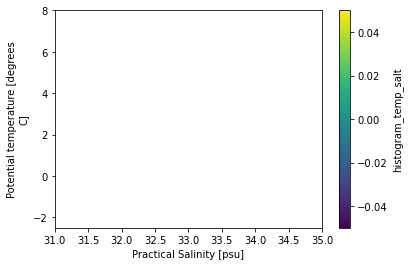

In [152]:
ts_hist_mean.where(ts_hist_mean>0).plot()

In [16]:
ts_hist_mean

<xarray.DataArray 'histogram_temp_salt' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [17]:
ts_hist_mean.load()

<xarray.DataArray 'histogram_temp_salt' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [22]:
ts_hist_mean.to_netcdf('ts_hist_mean_SODA_new.nc', mode='w')

# <span style='background :yellow'> Difference between SODA and WOA (1981-2010) </span>

##### diff between old soda and new soda (with avd'g values for spikes in dates 1993-12-30 in salt and 2018-12-24 in temp & salt)

In [32]:
diff_soda = soda - soda_old
diff_soda

<xarray.DataArray 'histogram_temp_salt' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

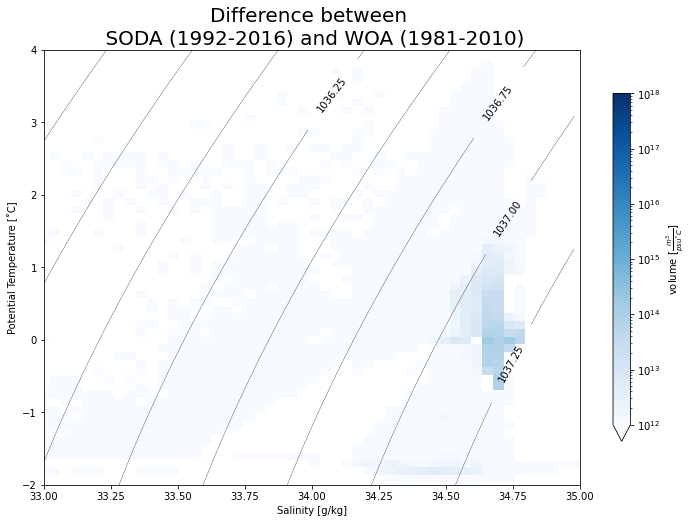

In [33]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
diff_soda.where(diff_soda>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Salinity [g/kg]')
ax.set_ylabel('Potential Temperature [˚C]')
ax.set_title('Difference between \n SODA (1992-2016) and WOA (1981-2010)', fontsize=20);
ax.set_xlim(33, 35)
ax.set_ylim(-2, 4);

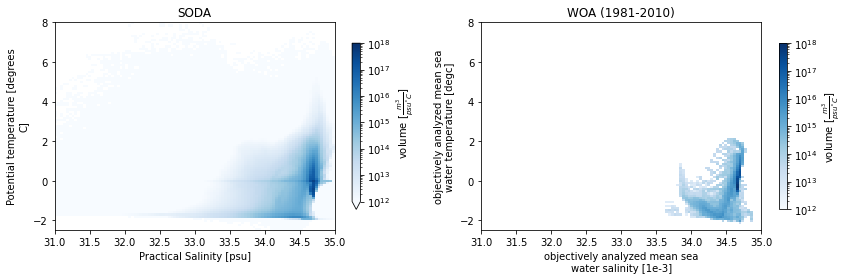

In [24]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

soda.where(soda>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax0)
ax0.set_title('SODA')

woa_8110.where(woa_8110>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax1)
ax1.set_title('WOA (1981-2010)')

plt.tight_layout();

In [25]:
diff_soda_woa8110 = soda - woa_8110
diff_soda_woa8110

<xarray.DataArray (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [26]:
sigma2 = jmd95numba.rho(diff_soda_woa8110.salt_bin, diff_soda_woa8110.theta_bin, 2000.)

In [29]:
sigma2

<xarray.DataArray 'salt_bin' (salt_bin: 99, theta_bin: 99)>
array([[1034.48446211, 1034.47686275, 1034.46911858, ..., 1033.15615741,
        1033.13654091, 1033.116816  ],
       [1034.51665196, 1034.50903907, 1034.50128143, ..., 1033.18726956,
        1033.1676439 , 1033.14790986],
       [1034.5488422 , 1034.54121579, 1034.53344467, ..., 1033.21838227,
        1033.19874744, 1033.17900428],
       ...,
       [1037.57657459, 1037.56768554, 1037.55865689, ..., 1036.14555665,
        1036.12506696, 1036.10447236],
       [1037.60880537, 1037.59990298, 1037.59086104, ..., 1036.17672527,
        1036.15622655, 1036.13562296],
       [1037.64103662, 1037.63212089, 1037.62306566, ..., 1036.2078945 ,
        1036.18738676, 1036.16677418]])
Coordinates:
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      Practical Salinity
    standard_name:  sea_water_salinity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          psu
    valid_range:    [-10. 100.]

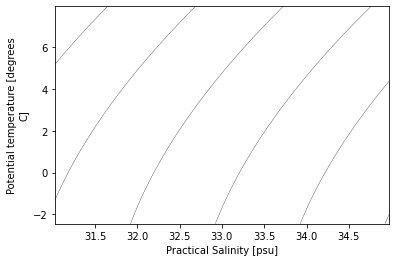

In [30]:
sigma2.transpose().plot.contour(colors='k', linewidths=0.3);

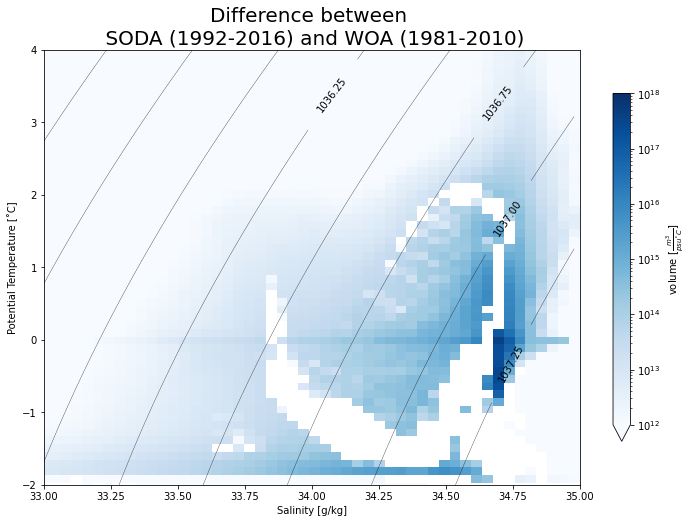

In [27]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
diff_soda_woa8110.where(diff_soda_woa8110>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Salinity [g/kg]')
ax.set_ylabel('Potential Temperature [˚C]')
ax.set_title('Difference between \n SODA (1992-2016) and WOA (1981-2010)', fontsize=20);
ax.set_xlim(33, 35)
ax.set_ylim(-2, 4);

## <span style='color:Purple'> Linear Scale

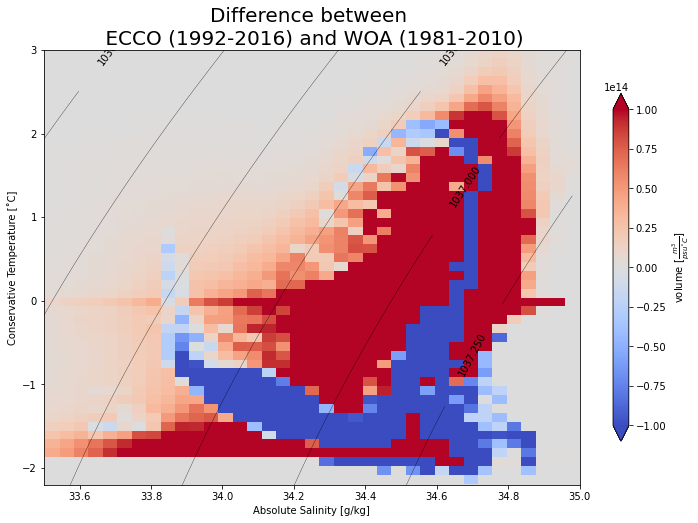

In [32]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
diff_soda_woa8110.plot(cmap='coolwarm', vmax=1e14,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Difference between \n ECCO (1992-2016) and WOA (1981-2010)', fontsize=20);
ax.set_xlim(33.5, 35)
ax.set_ylim(-2.2, 3);

## <span style='color:Purple'> Semi-Log Scale
using `SymLogNorm()` --> have to specify `linthresh` parameter - below this absolute value the colormap is linear, and outside the ± bounds cmap is logarithmic.

<ipython-input-33-fadce3a97437>:7: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  diff_soda_woa8110.plot(norm=SymLogNorm(linthresh=1e14), cmap='coolwarm', vmax=1e18,


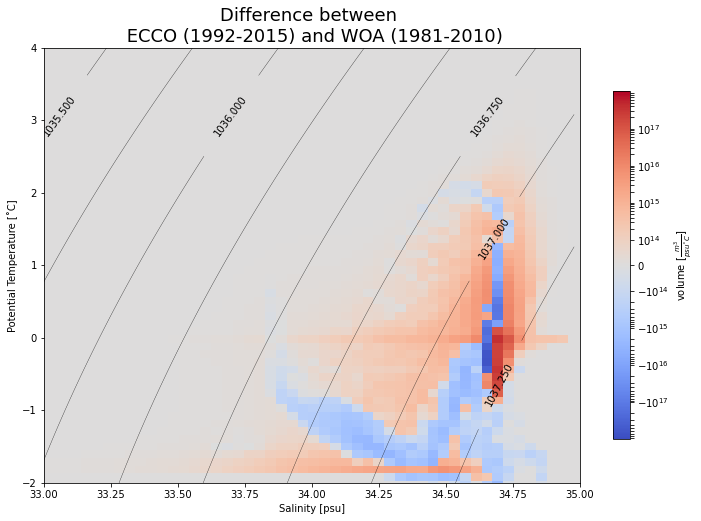

In [33]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
diff_soda_woa8110.plot(norm=SymLogNorm(linthresh=1e14), cmap='coolwarm', vmax=1e18,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Salinity [psu]')
ax.set_ylabel('Potential Temperature [˚C]')
ax.set_title('Difference between \n ECCO (1992-2015) and WOA (1981-2010)', fontsize=18);
ax.set_xlim(33, 35)
ax.set_ylim(-2, 4);

<ipython-input-34-451b5107f67e>:7: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  (diff_soda_woa8110/woa_8110).plot(norm=SymLogNorm(linthresh=10), cmap='coolwarm', vmax=1e4,


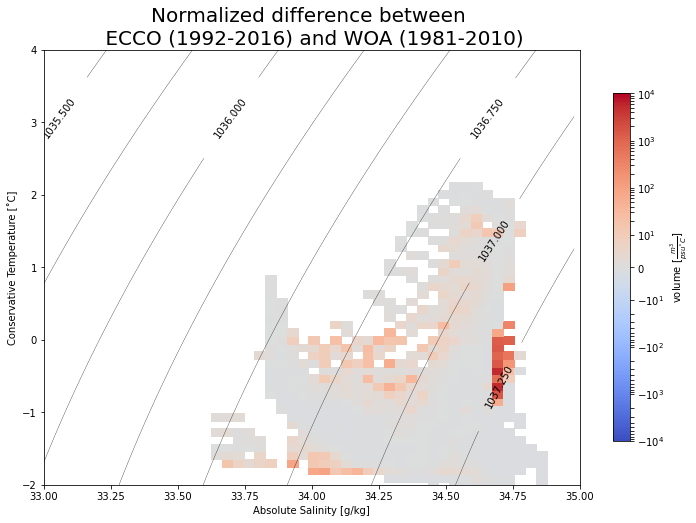

In [34]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
(diff_soda_woa8110/woa_8110).plot(norm=SymLogNorm(linthresh=10), cmap='coolwarm', vmax=1e4,
                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})
#got 0.4e18 from Linear Scale plot
#blue is positive
#red is negative

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Normalized difference between \n ECCO (1992-2016) and WOA (1981-2010)', fontsize=20);
ax.set_xlim(33, 35)
ax.set_ylim(-2, 4);

# <span style='background :yellow'> Difference between SODA and WOA (2005-2017)

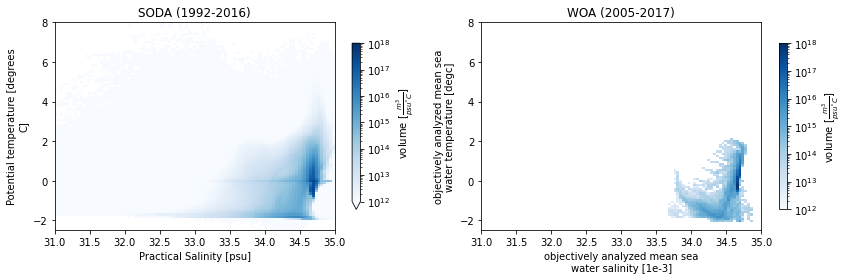

In [28]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

soda.where(soda>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax0)
ax0.set_title('SODA (1992-2016)')

woa_0517.where(woa_0517>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax1)
ax1.set_title('WOA (2005-2017)')

plt.tight_layout();

In [37]:
diff_soda_woa0517 = soda - woa_0517
diff_soda_woa0517

<xarray.DataArray (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

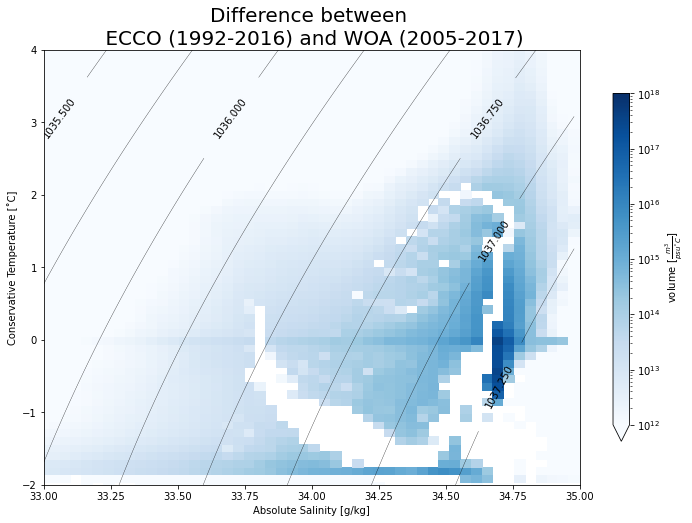

In [38]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
diff_soda_woa0517.where(diff_soda_woa0517>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Difference between \n ECCO (1992-2016) and WOA (2005-2017)', fontsize=20);
ax.set_xlim(33, 35)
ax.set_ylim(-2, 4);

## <span style='color:Purple'> Linear Scale

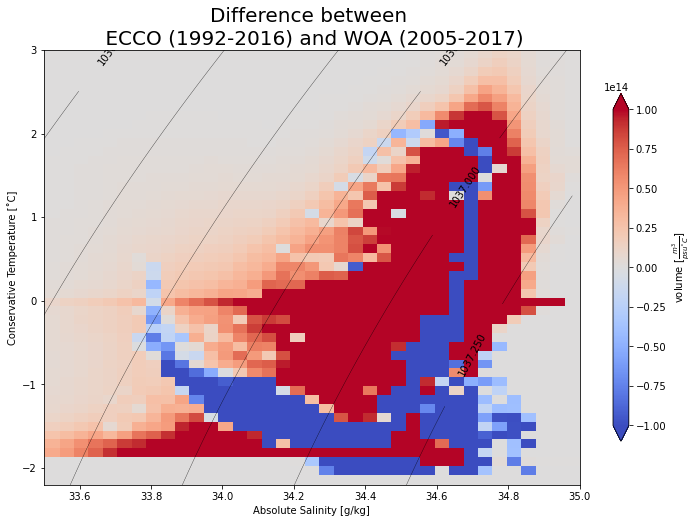

In [39]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
diff_soda_woa0517.plot(cmap='coolwarm', vmax=1e14, cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Difference between \n ECCO (1992-2016) and WOA (2005-2017)', fontsize=20);
ax.set_xlim(33.5, 35)
ax.set_ylim(-2.2, 3);

## <span style='color:Purple'> Semi-Log Scale
using `SymLogNorm()` --> have to specify `linthresh` parameter - below this absolute value the colormap is linear, and outside the ± bounds cmap is logarithmic.

<ipython-input-40-c86c91b82a14>:7: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  diff_soda_woa0517.plot(norm=SymLogNorm(linthresh=1e14), cmap='coolwarm', vmax=1e18,


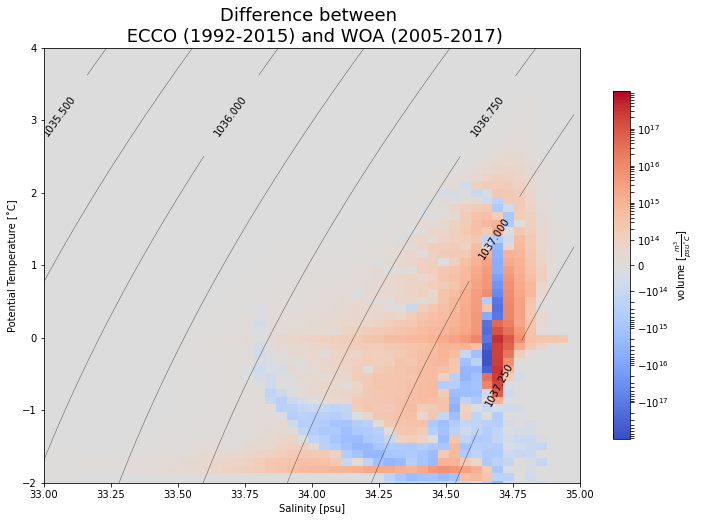

In [40]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
diff_soda_woa0517.plot(norm=SymLogNorm(linthresh=1e14), cmap='coolwarm', vmax=1e18,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Salinity [psu]')
ax.set_ylabel('Potential Temperature [˚C]')
ax.set_title('Difference between \n ECCO (1992-2015) and WOA (2005-2017)', fontsize=18);
ax.set_xlim(33, 35)
ax.set_ylim(-2, 4);

<ipython-input-41-6bfd35a54832>:7: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  (diff_soda_woa0517/woa_0517).plot(norm=SymLogNorm(linthresh=10), cmap='coolwarm', vmax=1e4,


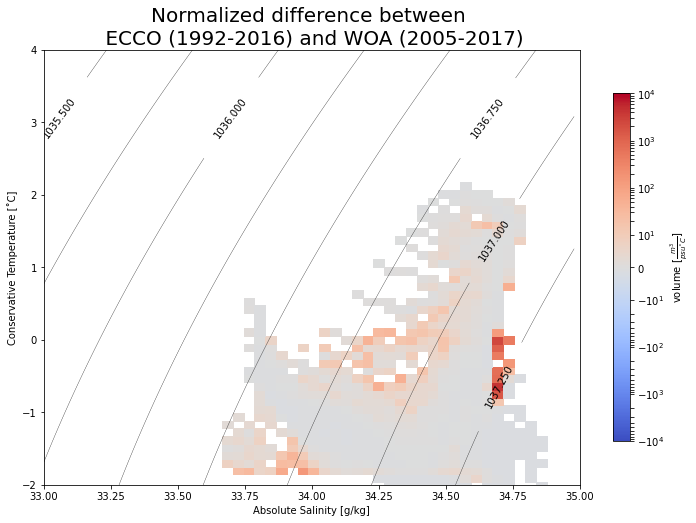

In [41]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
(diff_soda_woa0517/woa_0517).plot(norm=SymLogNorm(linthresh=10), cmap='coolwarm', vmax=1e4,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Normalized difference between \n ECCO (1992-2016) and WOA (2005-2017)', fontsize=20);
ax.set_xlim(33, 35)
ax.set_ylim(-2, 4);

## Gade Line

$$
T_P(S_P) = T_{ocean} + \frac{L_F}{C_P}(1 - \frac{S_{ocean}}{S_P})
$$
where $L_F = 334$ kJ kg$^-1$ (Latent heat of fusion for ice); and $C_P = 3.9$ kJ kg$^-1$ K$^-1$ (specific heat of water)

> Characteristic $T_{ocean}$ and $S_{ocean}$ for AABW is -0.7 ˚C and 34.6 psu

In [17]:
def gade_line(model):
    """Creating function to comput the Gade line for each model"""
    Tocean = -0.7
    Socean = 34.6
    LF = 334
    CP = 3.9
    #TP = model.theta_bin
    SP = model.salt_bin
    
    TP = Tocean + (LF / CP)*(1 - (Socean / SP))
    
    return(TP)

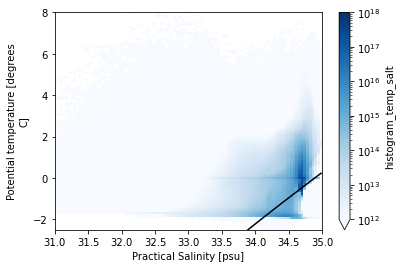

In [27]:
fig, ax = plt.subplots()

gade_line(ts_hist_mean).plot(ax=ax, color='k')
ts_hist_mean.where(ts_hist_mean>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18, ax=ax)

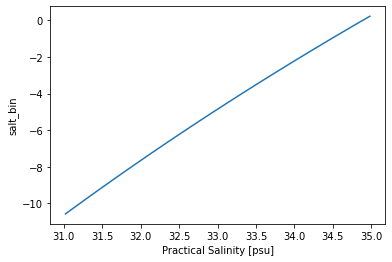

In [21]:
gade_line(ts_hist).plot()